In [7]:
import os
import numpy as np
from itertools import cycle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tensorboardX import SummaryWriter

from utils import weights_init
import matplotlib.pyplot as plt
from data_loader import MNIST_Paired
from torch.utils.data import DataLoader
from networks import Encoder, Decoder, Discriminator
from utils import imshow_grid, mse_loss, reparameterize, transform_config

import utils

In [2]:
import argparse
parser = argparse.ArgumentParser()

# add arguments
parser.add_argument('--cuda', type=bool, default=True, help="run the following code on a GPU")

parser.add_argument('--batch_size', type=int, default=64, help="batch size for training")
parser.add_argument('--image_size', type=int, default=28, help="height and width of the image")
parser.add_argument('--num_channels', type=int, default=1, help="number of channels in the image")
parser.add_argument('--initial_learning_rate', type=float, default=0.0001, help="starting learning rate")

parser.add_argument('--style_dim', type=int, default=16, help="dimension of style latent space")
parser.add_argument('--class_dim', type=int, default=16, help="dimension of class latent space")
parser.add_argument('--num_classes', type=int, default=10, help="number of classes on which the data set trained")


# arguments to control per iteration training of architecture
parser.add_argument('--generator_times', type=int, default=2, help="number of times the generator is run")
parser.add_argument('--discriminator_times', type=int, default=1, help="number of times the discriminator is run")
parser.add_argument(
    '--discriminator_limiting_accuracy', type=float, default=0.8, help="acc. at which discriminator is stopped training"
)

parser.add_argument('--beta_1', type=float, default=0.5, help="default beta_1 val for adam")
parser.add_argument('--beta_2', type=float, default=0.999, help="default beta_2 val for adam")

# paths to save models
parser.add_argument('--encoder_save', type=str, default='encoder', help="model save for encoder")
parser.add_argument('--decoder_save', type=str, default='decoder', help="model save for decoder")
parser.add_argument('--discriminator_save', type=str, default='discriminator', help="model save for discriminator")

parser.add_argument('--log_file', type=str, default='log.txt', help="text file to save training logs")

parser.add_argument('--load_saved', type=bool, default=False, help="flag to indicate if a saved model will be loaded")
parser.add_argument('--start_epoch', type=int, default=0, help="flag to set the starting epoch for training")
parser.add_argument('--end_epoch', type=int, default=50, help="flag to indicate the final epoch of training")

FLAGS = parser.parse_known_args()[0]

In [3]:
encoder = Encoder(style_dim=FLAGS.style_dim, class_dim=FLAGS.class_dim)
encoder.apply(weights_init)

decoder = Decoder(style_dim=FLAGS.style_dim, class_dim=FLAGS.class_dim)
decoder.apply(weights_init)

# load saved models
encoder.load_state_dict(torch.load(os.path.join('checkpoints', FLAGS.encoder_save), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join('checkpoints', FLAGS.decoder_save), map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
X_1 = torch.FloatTensor(FLAGS.batch_size, FLAGS.num_channels, FLAGS.image_size, FLAGS.image_size)
X_2 = torch.FloatTensor(FLAGS.batch_size, FLAGS.num_channels, FLAGS.image_size, FLAGS.image_size)

paired_mnist = MNIST_Paired(root='mnist', download=True, train=True, transform=transform_config)
loader = cycle(DataLoader(paired_mnist, batch_size=FLAGS.batch_size, shuffle=True, num_workers=0, drop_last=True))

image_batch_1, image_batch_2, _ = next(loader)

# shuffle batch1
image_batch_1 = image_batch_1[torch.randperm(FLAGS.batch_size)]

In [5]:
X_1.copy_(image_batch_1)
X_2.copy_(image_batch_2)

style_mu_1, style_logvar_1, class_1 = encoder(Variable(X_1))
style_1 = reparameterize(training=False, mu=style_mu_1, logvar=style_logvar_1)

_, __, class_2 = encoder(Variable(X_2))

reconstructed_X_1 = decoder(style_1, class_1)
reconstructed_X_2 = decoder(style_1, class_2)

In [8]:
def get_image_list(batch):
    return [batch[i, 0, :, :].detach().numpy() for i in range(batch.shape[0])]

re_x1_im = get_image_list(reconstructed_X_1)
re_x2_im = get_image_list(reconstructed_X_2)
x1_im = get_image_list(X_1)
x2_im = get_image_list(X_2)

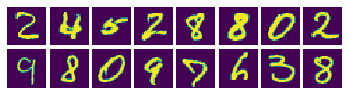

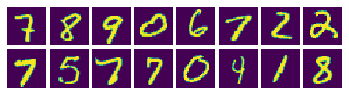

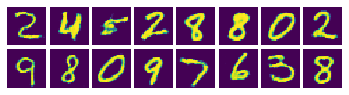

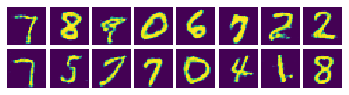

In [9]:
utils.imshow_grid(x1_im)
utils.imshow_grid(x2_im)
utils.imshow_grid(re_x1_im)
utils.imshow_grid(re_x2_im)